In [116]:
from sklearn import tree
import pandas as pd
import pathlib
import os
import numpy as np

In [117]:
here = pathlib.Path(os.path.abspath(''))
exercise_dir = here.parent
data_dir = exercise_dir.parent / "data"
train_df = pd.read_csv(data_dir / "titanic_train.csv")

# sex,  PClass, age: survived

In [118]:
train_df["TotalRelatives"] = train_df["SibSp"] + train_df["Parch"]
train_df = train_df.drop(columns=["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"])
train_df["Sex"] = train_df["Sex"].apply(lambda x: 0 if x == "female" else 1)
age_mean = train_df["Age"].mean()
train_df["Age"] = train_df["Age"].apply(lambda x: age_mean  if x == np.nan else x)#fill NaNs with distributed age

train_df


,PassengerId,Survived,Pclass,Sex,Age,TotalRelatives
0,565,0,3,0,NaN,0
1,858,1,1,1,51.0,0
2,129,1,3,0,NaN,2
3,612,0,3,1,NaN,0
4,67,1,2,0,29.0,0
...,...,...,...,...,...,...
752,816,0,1,1,NaN,0
753,254,0,3,1,30.0,1
754,642,1,1,0,24.0,0
755,480,1,3,0,2.0,1


In [119]:
# this decreases performance significantly:

def get_distributed_age():
    """
    Method that returns an random age based off the age distribution found in ALL of the data
    """
    age_ranges = {(0, 3), (3, 13 ), (13,  20), (20,  35), (35, 60), (60, 100)}
    age_group_distribution = [30/715, 41/715, 108/715,318/715, 195/715, 23/715]
    random_group = np.random.choice(age_ranges, p=age_group_distribution)#age groups according to analysis last week
    actual_value = np.random(random_group[0], random_group[1])#geerate actual random age based off the age groups upper and lower boundaries
    return actual_value
    
# train_df["Age"] = train_df["Age"].apply(lambda x: get_distributed_age() if x == np.nan else x)#fill NaNs with distributed age

In [120]:
from sklearn.model_selection import train_test_split
from sklearn import tree
classifier = tree.DecisionTreeClassifier(max_depth=7)
x = train_df.iloc[:, 2:]
y = train_df[["Survived"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)


In [121]:
classifier.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=7)

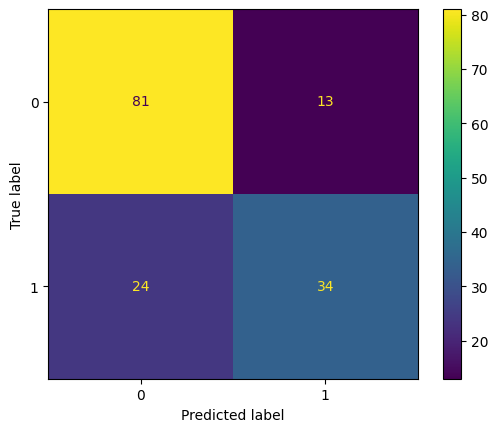

In [122]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, x_test, y_test)

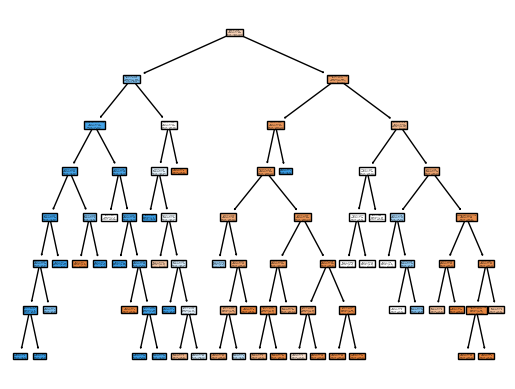

In [123]:
from sklearn.inspection import DecisionBoundaryDisplay, permutation_importance
import matplotlib.pyplot as plt
tree.plot_tree(classifier, feature_names=x_train.columns, class_names=["survived", "died"], filled=True)
plt.savefig('out.pdf')

In [124]:
from sklearn.metrics import matthews_corrcoef

y_pred = classifier.predict(x_test)
y_pred = pd.DataFrame(y_pred, columns=["prediction"], index=y_test.index)
matthews_corrcoef(y_test, y_pred)

0.4707866699220466

In [125]:
# is the model overfitted?
matthews_corrcoef(y_train, classifier.predict(x_train))


0.6462205167702145

In [126]:
# the data is well distributed and best with test_data of 20%
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, x, y, cv=5) 
scores

array([0.80921053, 0.83552632, 0.72847682, 0.78807947, 0.81456954])

In [127]:
#Testing with actual test data

test_df = pd.read_csv(data_dir / "titanic_test.csv")
test_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S
1,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
2,434,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,STON/O 2. 3101274,7.1250,NaN,S
3,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
4,224,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
129,386,0,2,"Davies, Mr. Charles Henry",male,18.0,0,0,S.O.C. 14879,73.5000,NaN,S
130,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,B94,S
131,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S
132,547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1,0,2908,26.0000,NaN,S


In [128]:
#removing unnecessary data
test_df["TotalRelatives"] = test_df["SibSp"] + test_df["Parch"]
test_df = test_df.drop(columns=["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"])
test_df["Sex"] = test_df["Sex"].apply(lambda x: 0 if x == "female" else 1)
age_mean = test_df["Age"].mean()
test_df["Age"] = train_df["Age"].apply(lambda x: age_mean  if x == np.nan else x)#fill NaNs with distributed age

x_test = test_df.iloc[:, 2:]
y_test = test_df[["Survived"]]

In [129]:
#run the model on test data
y_pred = classifier.predict(x_test)
y_pred = pd.DataFrame(y_pred, columns=["prediction"], index=y_test.index)
matthews_corrcoef(y_test, y_pred)

0.529821009880083